# 线性回归

## 术语

模型：y^=x1w1+x2w2+b

估计值：y^

权重：w

偏差：b

标签 y 和特征 x

## 损失函数

当个样本损损失函数L(i) = 0.5*(y^(i)-y(i))^2

总体损失函数 L = (1/n)*0.5*(y^-y)^2

目标：求 w 和 b 最小化损失函数

## 求解算法 —— 小批量随机梯度下降法

wi = wi - k*(∂L/∂wi)

写成梯度形式

w = w - k▽L

反复迭代即可。L 是这一批次样本的损失函数，其中 k = η/n，η 学习率，n 这一批样本数目，都是超参数。

## 单层神经网络表示线性回归

<img src="./img/A0301线性回归是一个单层神经网络.jpg"></img>

图中省略了权重 w 和偏置 b

全连接层 / 稠密曾：当前层中所有神经元每个都接受上层所有神经元的输出

## 从零实现线性回归

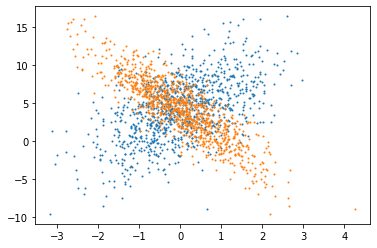

In [1]:
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random
import d2lzh

# 生成数据
num_inputs = 2 # 两个特征
num_examples = 1000 # 1000组数据
true_w = [2, -3.4] # 真实 w
true_b = 4.2 # 真实 b
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs)) # 特征集
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b # 标签
labels += nd.random.normal(scale=0.01, shape=labels.shape) # 加上噪声

plt.scatter(features[:, 0].asnumpy(), labels.asnumpy(), 1)
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1)

In [4]:
# 建立模型，初始化 w b
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
# 需要求梯度
w.attach_grad()
b.attach_grad()

batch_size = 10 # 一批数据大小
lr = 0.03 # 学习率
num_epochs = 3 # 迭代次数
net = d2lzh.linreg # 线性回归
loss = d2lzh.squared_loss # 损失

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in d2lzh.data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        d2lzh.sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

# 查看训练效果
print(f"true_w={true_w},w={w}")
print(f"true_b={true_b},w={b}")


epoch 1, loss 0.035092
epoch 2, loss 0.000121
epoch 3, loss 0.000048
true_w=[2, -3.4],w=
[[ 1.999522 ]
 [-3.4001455]]
<NDArray 2x1 @cpu(0)>
true_b=4.2,w=
[4.199727]
<NDArray 1 @cpu(0)>


# 使用 MXNet 的 Gluon 接口实现线性回归，即单层神经网路

In [1]:
from mxnet import autograd, nd
# 生成数据
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 读取数据
from mxnet.gluon import data as gdata
batch_size = 10
# 将训练数据的特征和标签组合
dataset = gdata.ArrayDataset(features, labels)
# 随机读取小批量
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

# 初始化网络。Sequential实例可以看作是一个串联各个层的容器
from mxnet.gluon import nn
net = nn.Sequential()
# 加入一个全连接层，输出 1
net.add(nn.Dense(1))

# 初始化模型参数
from mxnet import init
net.initialize(init.Normal(sigma=0.01))

# 定义损失函数
from mxnet.gluon import loss as gloss
loss = gloss.L2Loss()  # 平方损失又称L2范数损失

# 定义优化算法
from mxnet import gluon
# 指定学习率为0.03的小批量随机梯度下降（sgd）为优化算法
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))

dense = net[0]
print(f"tw={true_w}, w={dense.weight.data()}")
print(f"tb={true_b}, b={dense.bias.data()}")

epoch 1, loss: 0.034956
epoch 2, loss: 0.000126
epoch 3, loss: 0.000048
tw=[2, -3.4], w=
[[ 1.9994364 -3.400108 ]]
<NDArray 1x2 @cpu(0)>
tb=4.2, b=
[4.199967]
<NDArray 1 @cpu(0)>
